In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the dataset
file_path = "/Users/sarayu.mangapathi/Downloads/crime_dataset_india.csv"
df = pd.read_csv(file_path)


# Clean the date columns by removing any extra whitespace
df['Date Reported'] = df['Date Reported'].str.strip()
df['Date of Occurrence'] = df['Date of Occurrence'].str.strip()
df['Time of Occurrence'] = df['Time of Occurrence'].str.strip()

# Convert date columns to datetime format with error handling
df['Date Reported'] = pd.to_datetime(df['Date Reported'], errors='coerce')
df['Date of Occurrence'] = pd.to_datetime(df['Date of Occurrence'], errors='coerce')

# For Time of Occurrence, we'll extract just the time part
# First convert to datetime, then extract time
df['Time of Occurrence'] = pd.to_datetime(df['Time of Occurrence'], errors='coerce').dt.time

# Drop rows with invalid dates if needed
df = df.dropna(subset=['Date Reported', 'Date of Occurrence'])

# Extract features from datetime
df['Reported_Hour'] = df['Date Reported'].dt.hour
df['Occurrence_Hour'] = pd.to_datetime(df['Time of Occurrence'].astype(str)).dt.hour
df['Day_of_Week'] = df['Date of Occurrence'].dt.day_name()
df['Month'] = df['Date of Occurrence'].dt.month_name()

# Check for missing values
print("Missing values after processing:")
print(df.isnull().sum())

# Verify the date conversion
print("\nSample dates after conversion:")
print(df[['Date Reported', 'Date of Occurrence', 'Time of Occurrence']].head())

Missing values after processing:
Report Number            0
Date Reported            0
Date of Occurrence       0
Time of Occurrence    1441
City                     0
Crime Code               0
Crime Description        0
Victim Age               0
Victim Gender            0
Weapon Used           2312
Crime Domain             0
Police Deployed          0
Case Closed              0
Date Case Closed      7951
Reported_Hour            0
Occurrence_Hour       1441
Day_of_Week              0
Month                    0
dtype: int64

Sample dates after conversion:
        Date Reported  Date of Occurrence Time of Occurrence
0 2020-02-01 00:00:00 2020-01-01 00:00:00           01:11:00
1 2020-01-01 19:00:00 2020-01-01 01:00:00           06:26:00
2 2020-02-01 05:00:00 2020-01-01 02:00:00           14:30:00
3 2020-01-01 05:00:00 2020-01-01 03:00:00           14:46:00
4 2020-01-01 21:00:00 2020-01-01 04:00:00           16:51:00


/var/folders/h5/j3f74bss10dbbr090b7t0kx00000gn/T/ipykernel_4003/89980274.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Occurrence_Hour'] = pd.to_datetime(df['Time of Occurrence'].astype(str)).dt.hour


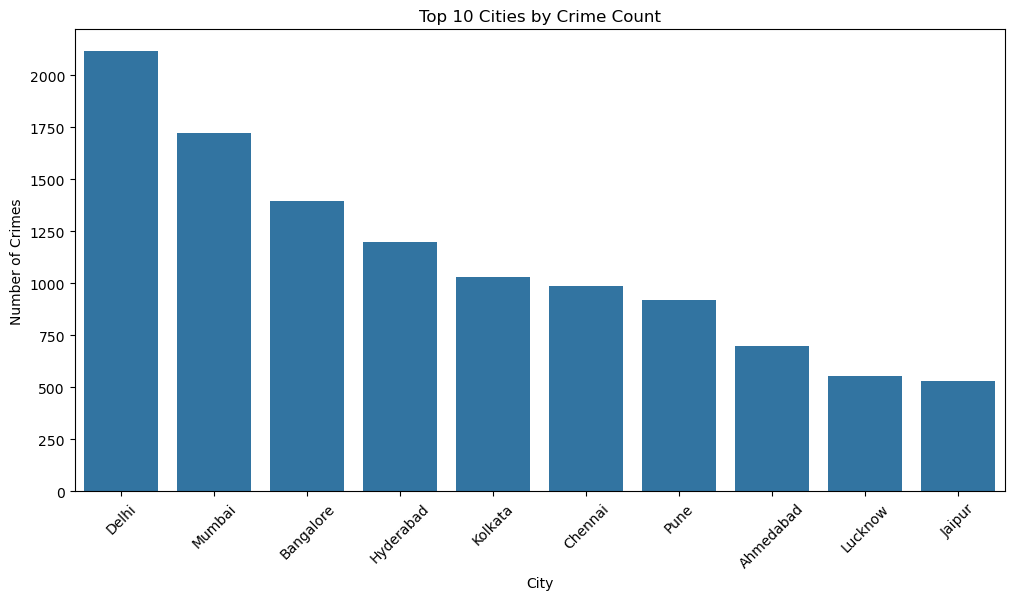

In [2]:
plt.figure(figsize=(12,6))
city_counts = df['City'].value_counts().head(10)
sns.barplot(x=city_counts.index, y=city_counts.values)
plt.title('Top 10 Cities by Crime Count')
plt.xticks(rotation=45)
plt.ylabel('Number of Crimes')
plt.show()

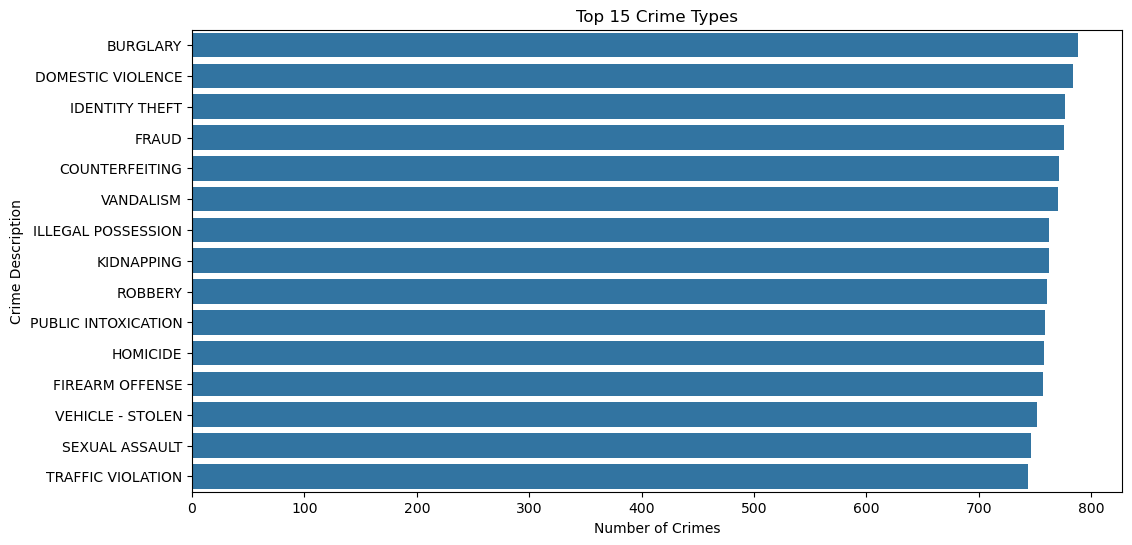

In [3]:
plt.figure(figsize=(12,6))
crime_counts = df['Crime Description'].value_counts().head(15)
sns.barplot(x=crime_counts.values, y=crime_counts.index)
plt.title('Top 15 Crime Types')
plt.xlabel('Number of Crimes')
plt.show()

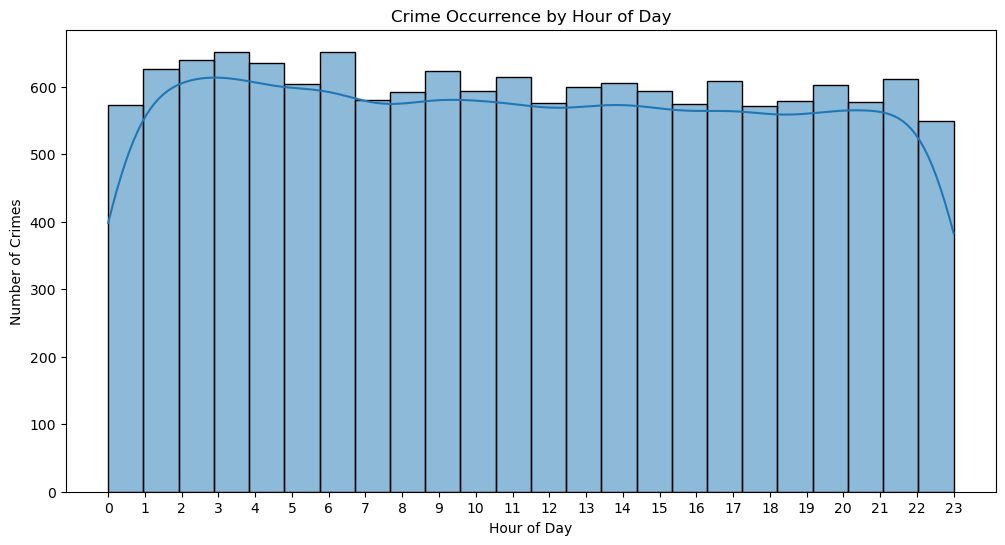

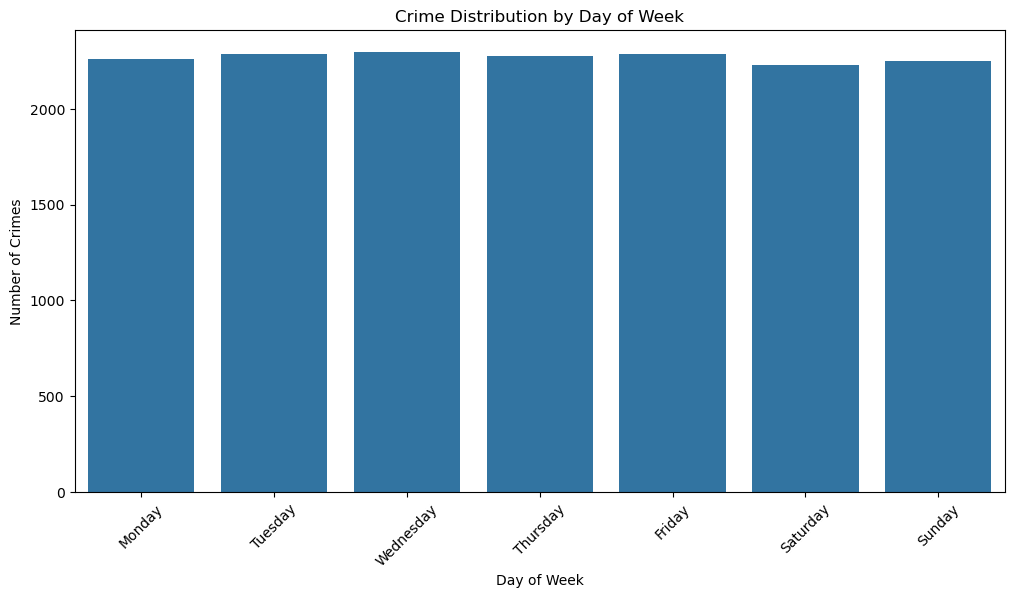

In [4]:
# Hourly crime distribution
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='Occurrence_Hour', bins=24, kde=True)
plt.title('Crime Occurrence by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crimes')
plt.xticks(range(0,24))
plt.show()

# Weekly pattern
plt.figure(figsize=(12,6))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df, x='Day_of_Week', order=day_order)
plt.title('Crime Distribution by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.show()

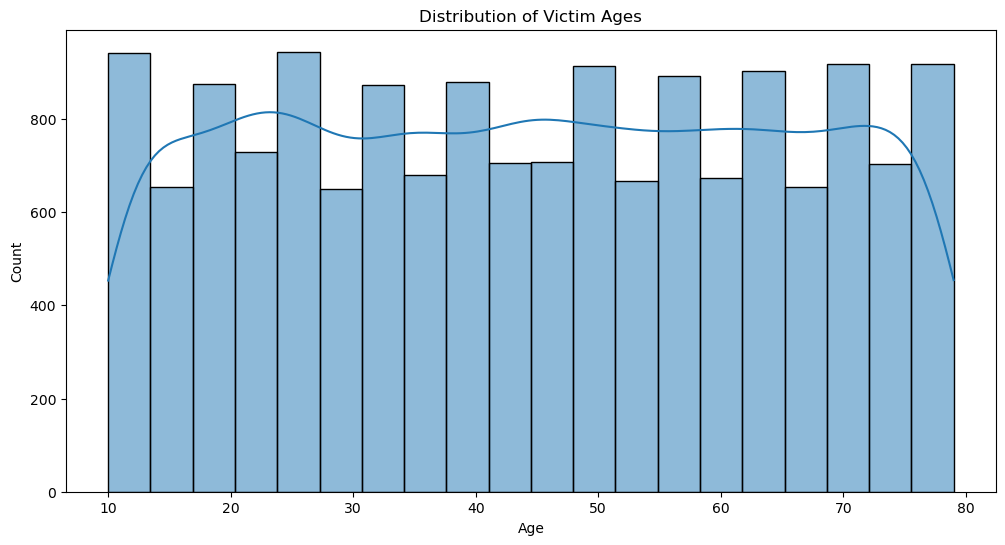

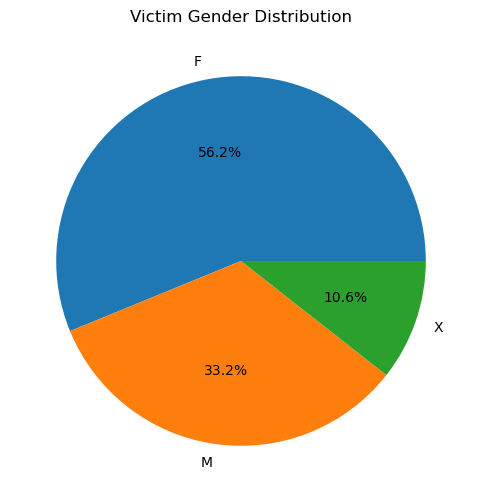

In [5]:
# Victim age distribution
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='Victim Age', bins=20, kde=True)
plt.title('Distribution of Victim Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Victim gender distribution
plt.figure(figsize=(8,6))
df['Victim Gender'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Victim Gender Distribution')
plt.ylabel('')
plt.show()

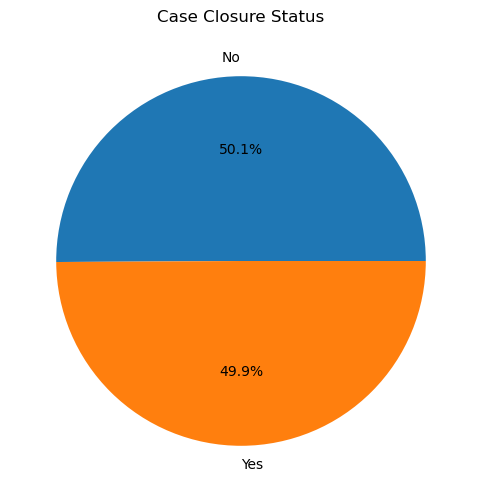

In [6]:
plt.figure(figsize=(8,6))
df['Case Closed'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Case Closure Status')
plt.ylabel('')
plt.show()

/var/folders/h5/j3f74bss10dbbr090b7t0kx00000gn/T/ipykernel_4003/145427419.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=city_crime, x='Count', y='City', palette=palette)


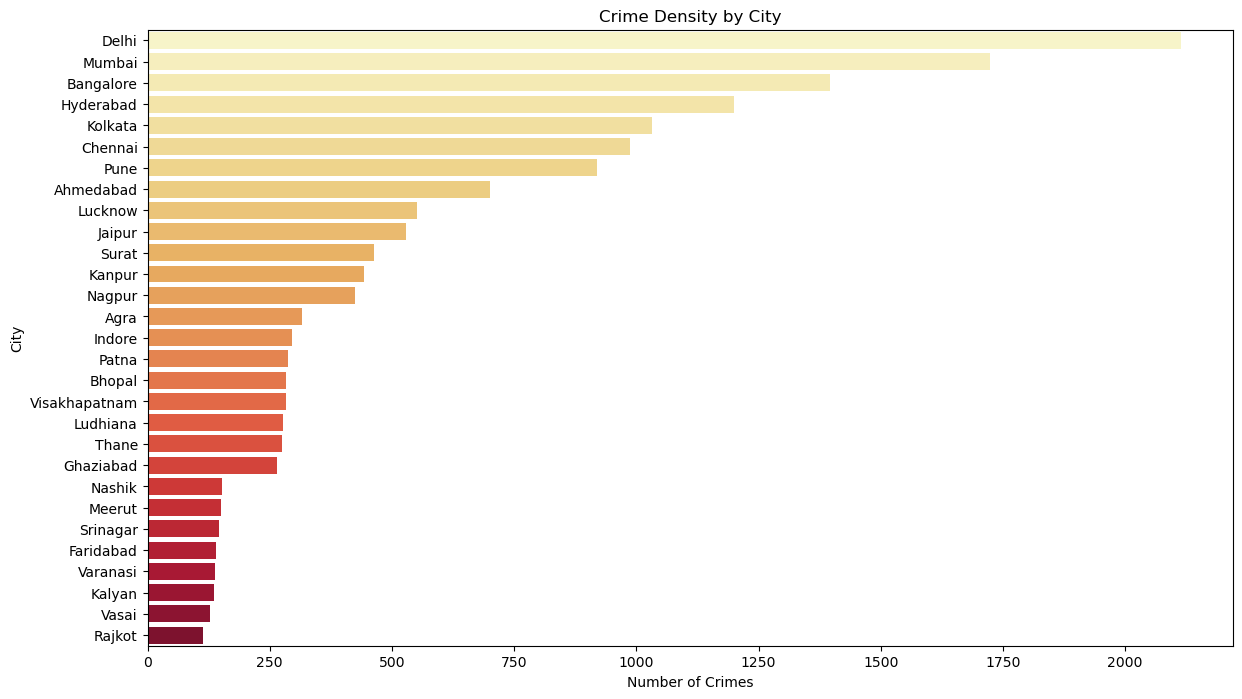

In [7]:
# Crime density by city
plt.figure(figsize=(14,8))
city_crime = df['City'].value_counts().reset_index()
city_crime.columns = ['City', 'Count']

# Create a custom color palette
palette = sns.color_palette("YlOrRd", len(city_crime))

sns.barplot(data=city_crime, x='Count', y='City', palette=palette)
plt.title('Crime Density by City')
plt.xlabel('Number of Crimes')
plt.ylabel('City')
plt.show()

In [25]:
!pip install folium
!pip install geopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.8 MB/s eta 0:00:00


In [31]:
import folium
import time
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError

# Get unique cities
unique_cities = crime_data["City"].unique()

# Initialize geolocator
geolocator = Nominatim(user_agent="crime_analysis")

# Get latitude and longitude for each city
city_coords = {}
for city in unique_cities:
    try:
        location = geolocator.geocode(city, timeout=10)
        if location:
            city_coords[city] = (location.latitude, location.longitude)
        else:
            city_coords[city] = None
    except (GeocoderTimedOut, GeocoderServiceError):
        print(f"Geocoding failed for {city}")
        city_coords[city] = None
    
    time.sleep(1)  # Prevent API rate limit issues

# Remove cities without coordinates
city_coords = {city: coords for city, coords in city_coords.items() if coords}

# Ensure there is at least one valid city to center the map
map_center = list(city_coords.values())[0] if city_coords else [20.5937, 78.9629]

# Create Folium map
crime_map = folium.Map(location=map_center, zoom_start=5)

# Precompute crime counts
crime_counts = crime_data["City"].value_counts().to_dict()

# Add markers for each city
for city, coords in city_coords.items():
    crime_count = crime_counts.get(city, 0)
    folium.Marker(
        location=coords,
        popup=f"{city}: {crime_count} crimes",
        icon=folium.Icon(color="red", icon="info-sign"),
    ).add_to(crime_map)

# Display map
crime_map

In [32]:
from folium.plugins import HeatMap

# Ensure map_center is valid
map_center = list(city_coords.values())[0] if city_coords else [20.5937, 78.9629]

# Precompute crime counts for efficiency
crime_counts = crime_data["City"].value_counts().to_dict()

# Prepare data for heatmap (only cities with valid coordinates)
heatmap_data = [
    (coords[0], coords[1], crime_counts.get(city, 0))
    for city, coords in city_coords.items()
]

# Create a heatmap
heatmap_map = folium.Map(location=map_center, zoom_start=5)

if heatmap_data:
    HeatMap(heatmap_data, radius=15, blur=10, max_zoom=1).add_to(heatmap_map)
else:
    print("No valid data for heatmap.")

# Display the heatmap
heatmap_map

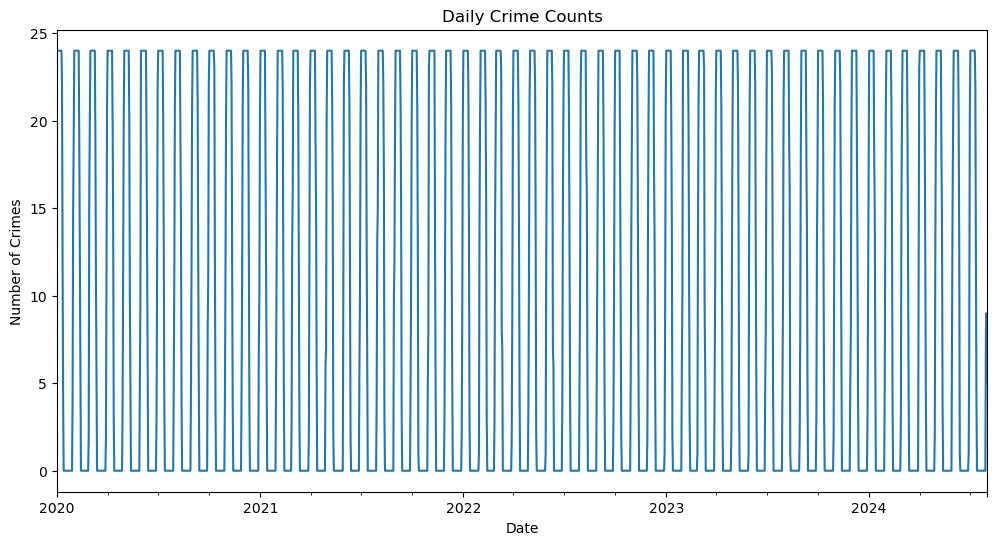

Original Series:
ADF Statistic: -27.392114723084493
p-value: 0.0
Critical Values:
	1%: -3.4343193954605002
	5%: -2.8632932610713193
	10%: -2.567703395408632


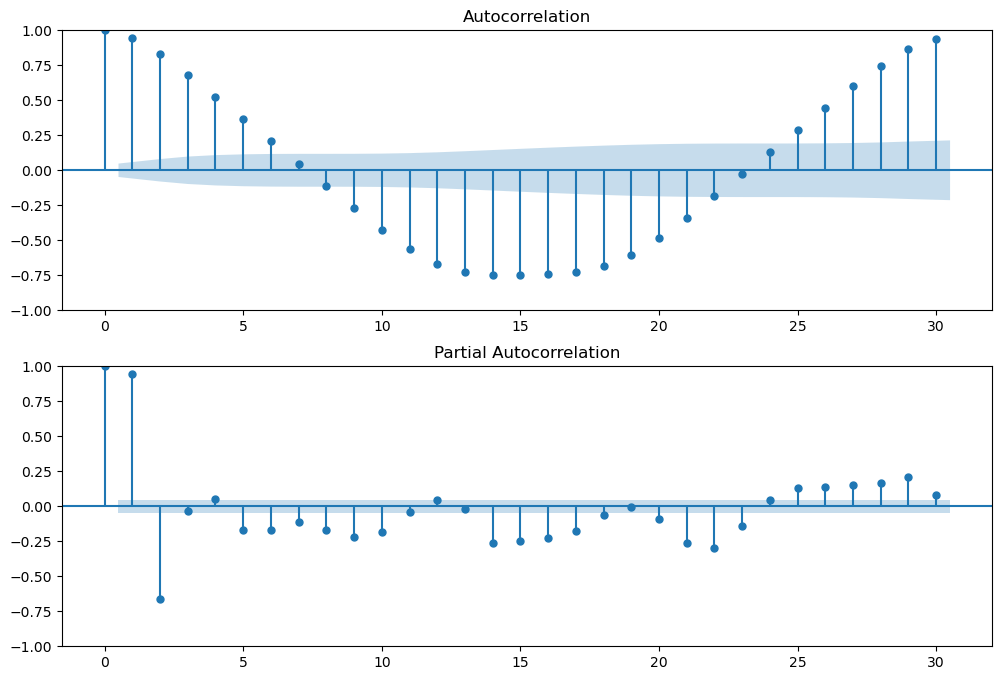

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1644
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3949.519
Date:                           Thu, 27 Mar 2025   AIC                           7909.037
Time:                                   17:17:17   BIC                           7936.010
Sample:                               01-01-2020   HQIC                          7919.045
                                    - 07-01-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5758      0.027     20.953      0.000       0.522       0.630
ma.L1          0.0921      0.033      2.782

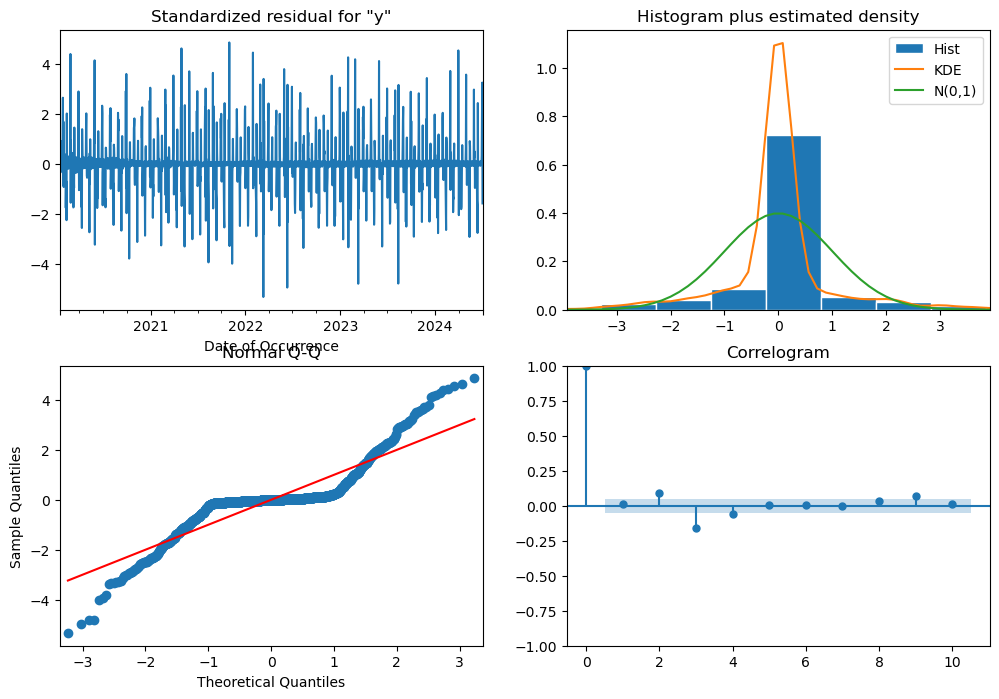

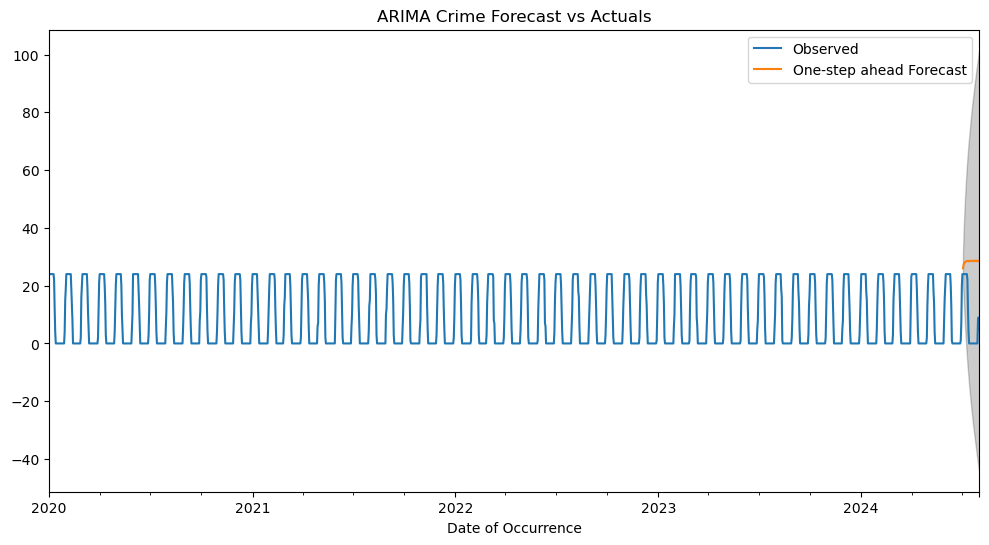

Mean Squared Error: 514.92
Root Mean Squared Error: 22.69
Mean Absolute Error: 19.95


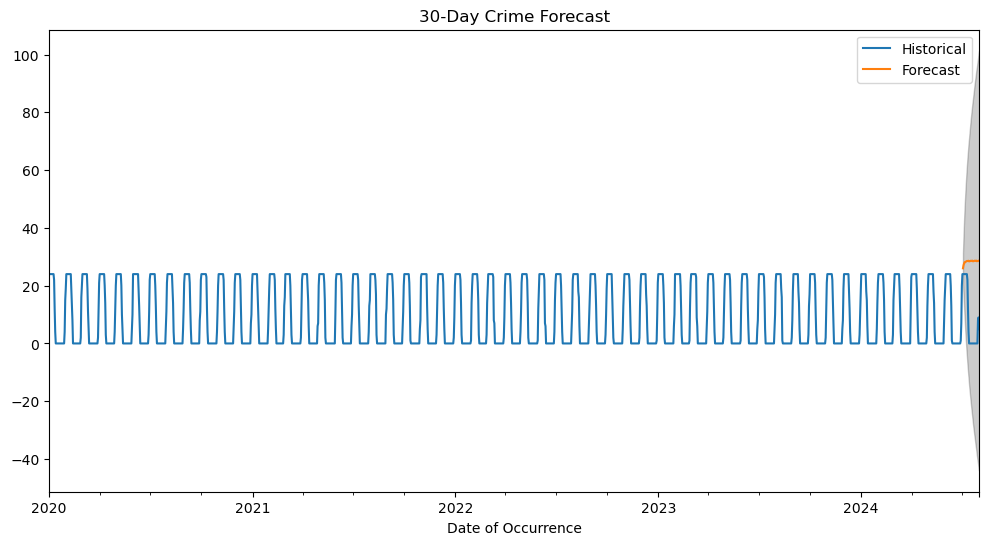

Forecasted Crime Counts:
            Predicted Crimes
2024-07-02         26.008117
2024-07-03         27.075382
2024-07-04         27.681432
2024-07-05         28.113128
2024-07-06         28.105206
2024-07-07         28.306022
2024-07-08         28.396532
2024-07-09         28.547086
2024-07-10         28.544806
2024-07-11         28.535032
2024-07-12         28.612190
2024-07-13         28.400392
2024-07-14         28.484249
2024-07-15         28.507257
2024-07-16         28.618927
2024-07-17         28.594257
2024-07-18         28.571593
2024-07-19         28.641329
2024-07-20         28.425257
2024-07-21         28.506653
2024-07-22         28.528244
2024-07-23         28.639098
2024-07-24         28.613959
2024-07-25         28.591024
2024-07-26         28.660604
2024-07-27         28.444442
2024-07-28         28.525787
2024-07-29         28.547348
2024-07-30         28.658185
2024-07-31         28.633036


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Convert to daily crime counts
daily_crimes = df.groupby(df['Date of Occurrence'].dt.date).size()
daily_crimes.index = pd.to_datetime(daily_crimes.index)
daily_crimes = daily_crimes.asfreq('D').fillna(0)  # Ensure daily frequency, fill missing days with 0

# Plot the time series
plt.figure(figsize=(12, 6))
daily_crimes.plot()
plt.title('Daily Crime Counts')
plt.ylabel('Number of Crimes')
plt.xlabel('Date')
plt.show()

# Augmented Dickey-Fuller test for stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

print("Original Series:")
test_stationarity(daily_crimes)

# If not stationary, apply differencing
if adfuller(daily_crimes)[1] > 0.05:
    print("\nSeries is not stationary - applying differencing")
    daily_crimes_diff = daily_crimes.diff().dropna()
    
    print("\nAfter 1st Differencing:")
    test_stationarity(daily_crimes_diff)
    
    # Plot differenced series
    plt.figure(figsize=(12, 6))
    daily_crimes_diff.plot()
    plt.title('Differenced Daily Crime Counts')
    plt.show()
else:
    daily_crimes_diff = daily_crimes.copy()


# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(daily_crimes_diff, lags=30, ax=ax1)
plot_pacf(daily_crimes_diff, lags=30, ax=ax2)
plt.show()


# Split into train and test sets (last 30 days for testing)
train = daily_crimes[:-30]
test = daily_crimes[-30:]

# Fit ARIMA model
# Parameters should be adjusted based on ACF/PACF analysis
model = SARIMAX(train,
               order=(1, 1, 1),       # (p, d, q)
               seasonal_order=(1, 1, 1, 7),  # Seasonal component (weekly)
               enforce_stationarity=False,
               enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())

# Plot diagnostics
results.plot_diagnostics(figsize=(12, 8))
plt.show()


# Get predictions
pred = results.get_prediction(start=pd.to_datetime(test.index[0]),
                            end=pd.to_datetime(test.index[-1]),
                            dynamic=False)
pred_ci = pred.conf_int()

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
ax = daily_crimes.plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast')
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], color='k', alpha=0.2)
plt.title('ARIMA Crime Forecast vs Actuals')
plt.legend()
plt.show()

# Calculate error metrics
y_forecasted = pred.predicted_mean
y_truth = test

mse = mean_squared_error(y_truth, y_forecasted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_truth, y_forecasted)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')


# Forecast for next 30 days
forecast_steps = 30
forecast = results.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

# Plot
plt.figure(figsize=(12, 6))
ax = daily_crimes.plot(label='Historical')
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(forecast_ci.index,
               forecast_ci.iloc[:, 0],
               forecast_ci.iloc[:, 1], color='k', alpha=0.2)
plt.title(f'{forecast_steps}-Day Crime Forecast')
plt.legend()
plt.show()

# Print forecast values
print("Forecasted Crime Counts:")
print(forecast.predicted_mean.to_frame('Predicted Crimes'))

X shape: (40160, 35), y shape: (40160,)
[0]	validation_0-mlogloss:2.09096
[1]	validation_0-mlogloss:1.72688
[2]	validation_0-mlogloss:1.48218
[3]	validation_0-mlogloss:1.31575
[4]	validation_0-mlogloss:1.16680
[5]	validation_0-mlogloss:1.03767
[6]	validation_0-mlogloss:0.94007
[7]	validation_0-mlogloss:0.83834
[8]	validation_0-mlogloss:0.75393
[9]	validation_0-mlogloss:0.68249
[10]	validation_0-mlogloss:0.62276
[11]	validation_0-mlogloss:0.56804
[12]	validation_0-mlogloss:0.51473
[13]	validation_0-mlogloss:0.47487
[14]	validation_0-mlogloss:0.42905
[15]	validation_0-mlogloss:0.38850
[16]	validation_0-mlogloss:0.35160
[17]	validation_0-mlogloss:0.31835
[18]	validation_0-mlogloss:0.28844
[19]	validation_0-mlogloss:0.26244
[20]	validation_0-mlogloss:0.23984
[21]	validation_0-mlogloss:0.21756
[22]	validation_0-mlogloss:0.19813
[23]	validation_0-mlogloss:0.18190
[24]	validation_0-mlogloss:0.16572
[25]	validation_0-mlogloss:0.15045
[26]	validation_0-mlogloss:0.13718
[27]	validation_0-mloglos

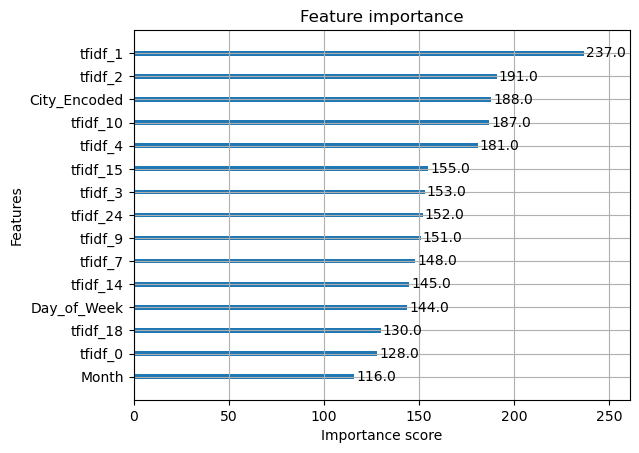

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.metrics import classification_report

# Load and prepare data
df = pd.read_csv('/Users/sarayu.mangapathi/Downloads/crime_dataset_india.csv')

# Basic cleaning
df = df.dropna(subset=['Crime Description', 'City', 'Victim Gender', 'Date of Occurrence'])

# Feature engineering
df['Hour_of_Day'] = pd.to_datetime(df['Time of Occurrence'], errors='coerce').dt.hour
df['Day_of_Week'] = pd.to_datetime(df['Date of Occurrence'], errors='coerce').dt.dayofweek
df['Month'] = pd.to_datetime(df['Date of Occurrence'], errors='coerce').dt.month

# Handle missing values in Hour_of_Day (created from Time of Occurrence)
df['Hour_of_Day'] = df['Hour_of_Day'].fillna(df['Hour_of_Day'].median())

# Encode categorical variables
le_crime = LabelEncoder()
le_city = LabelEncoder()
df['Crime_Type_Encoded'] = le_crime.fit_transform(df['Crime Description'])
df['City_Encoded'] = le_city.fit_transform(df['City'])

# Text feature extraction (with proper handling)
tfidf = TfidfVectorizer(max_features=50, stop_words='english')
crime_desc_text = df['Crime Description'].fillna('')
text_features = tfidf.fit_transform(crime_desc_text)

# Create feature matrix - ensure all features have same number of samples
X_numeric = df[['Hour_of_Day', 'Day_of_Week', 'Month', 'City_Encoded']]
X_gender = pd.get_dummies(df['Victim Gender'], prefix='gender')
X_text = pd.DataFrame(text_features.toarray(), 
                     columns=[f"tfidf_{i}" for i in range(text_features.shape[1])],
                     index=df.index)

# Combine features - this ensures alignment by index
X = pd.concat([X_numeric, X_gender, X_text], axis=1)
y = df['Crime_Type_Encoded']

# Verify shapes match
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Remove any remaining NaN values (just in case)
valid_samples = ~X.isnull().any(axis=1)
X = X[valid_samples]
y = y[valid_samples]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y  # Important for imbalanced classes
)

# XGBoost model
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(le_crime.classes_),
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=10
)

# Train with evaluation set
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

# Evaluation
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_crime.classes_))

# Feature importance
xgb.plot_importance(model, max_num_features=15)
plt.show()

[0]	validation_0-mlogloss:2.04439
[1]	validation_0-mlogloss:1.69250
[2]	validation_0-mlogloss:1.48001
[3]	validation_0-mlogloss:1.30336
[4]	validation_0-mlogloss:1.16499
[5]	validation_0-mlogloss:1.04044
[6]	validation_0-mlogloss:0.93614
[7]	validation_0-mlogloss:0.83499
[8]	validation_0-mlogloss:0.76404
[9]	validation_0-mlogloss:0.69245
[10]	validation_0-mlogloss:0.62961
[11]	validation_0-mlogloss:0.57034
[12]	validation_0-mlogloss:0.51626
[13]	validation_0-mlogloss:0.47186
[14]	validation_0-mlogloss:0.43088
[15]	validation_0-mlogloss:0.39510
[16]	validation_0-mlogloss:0.36036
[17]	validation_0-mlogloss:0.32749
[18]	validation_0-mlogloss:0.29670
[19]	validation_0-mlogloss:0.27079
[20]	validation_0-mlogloss:0.24709
[21]	validation_0-mlogloss:0.22586
[22]	validation_0-mlogloss:0.20885
[23]	validation_0-mlogloss:0.19325
[24]	validation_0-mlogloss:0.17630
[25]	validation_0-mlogloss:0.16218
[26]	validation_0-mlogloss:0.14916
[27]	validation_0-mlogloss:0.13596
[28]	validation_0-mlogloss:0.1

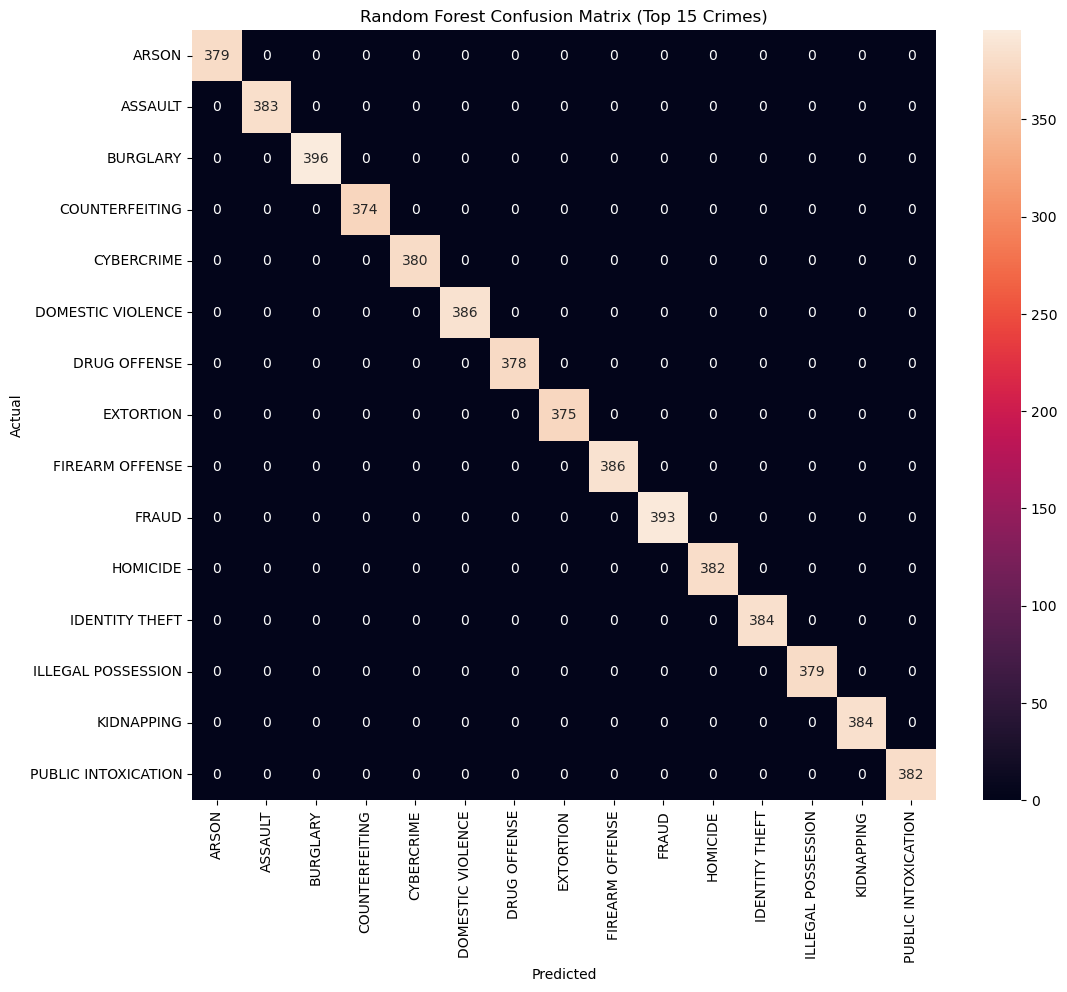


XGBoost Evaluation:
Accuracy: 1.0
Weighted Precision: 1.0
Weighted Recall: 1.0
Weighted F1-score: 1.0

Classification Report:
                     precision    recall  f1-score   support

              ARSON       1.00      1.00      1.00       379
            ASSAULT       1.00      1.00      1.00       383
           BURGLARY       1.00      1.00      1.00       396
     COUNTERFEITING       1.00      1.00      1.00       374
         CYBERCRIME       1.00      1.00      1.00       380
  DOMESTIC VIOLENCE       1.00      1.00      1.00       386
       DRUG OFFENSE       1.00      1.00      1.00       378
          EXTORTION       1.00      1.00      1.00       375
    FIREARM OFFENSE       1.00      1.00      1.00       386
              FRAUD       1.00      1.00      1.00       393
           HOMICIDE       1.00      1.00      1.00       382
     IDENTITY THEFT       1.00      1.00      1.00       384
 ILLEGAL POSSESSION       1.00      1.00      1.00       379
         KIDNAPPIN

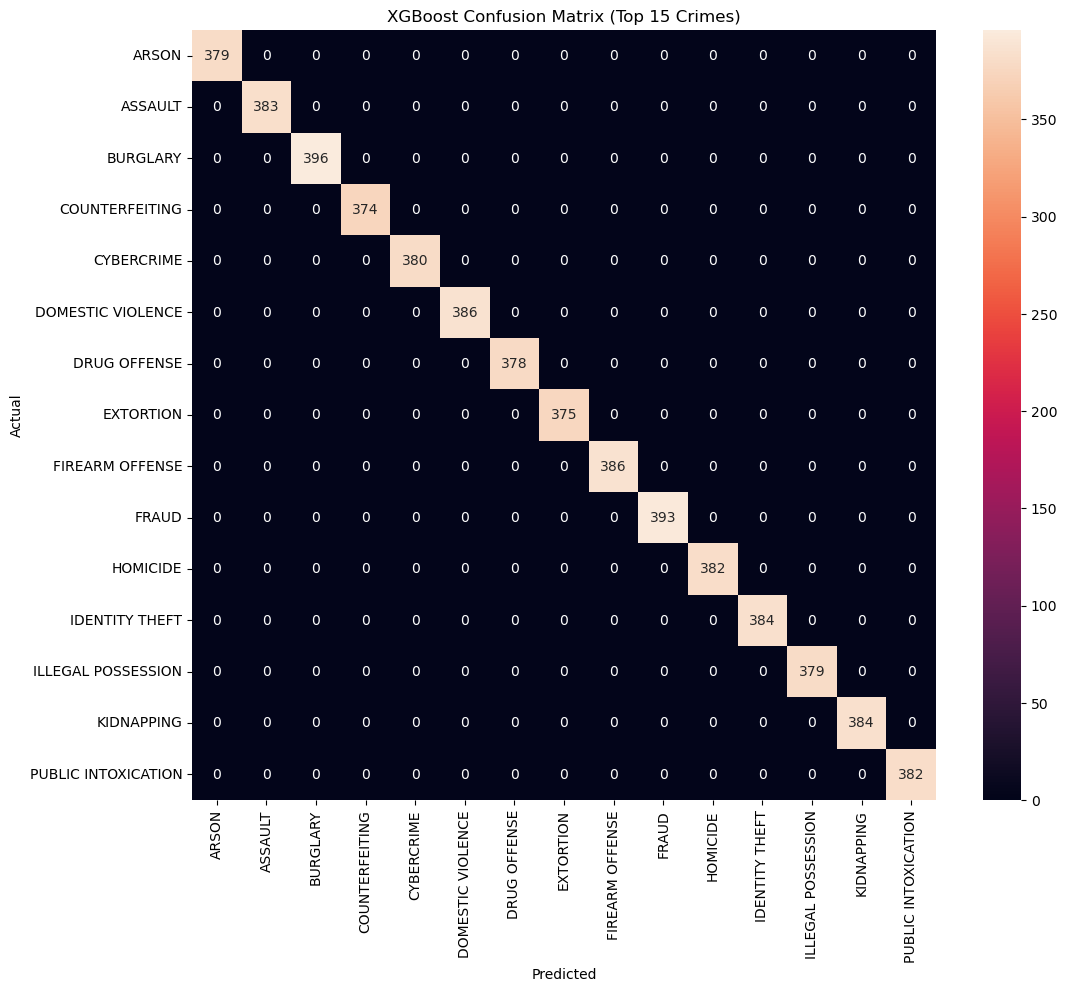

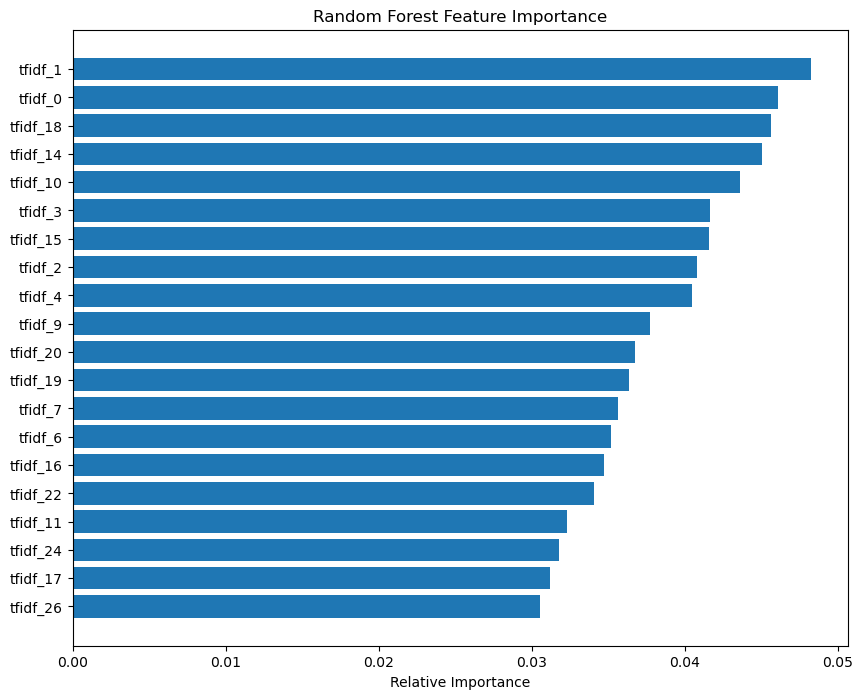

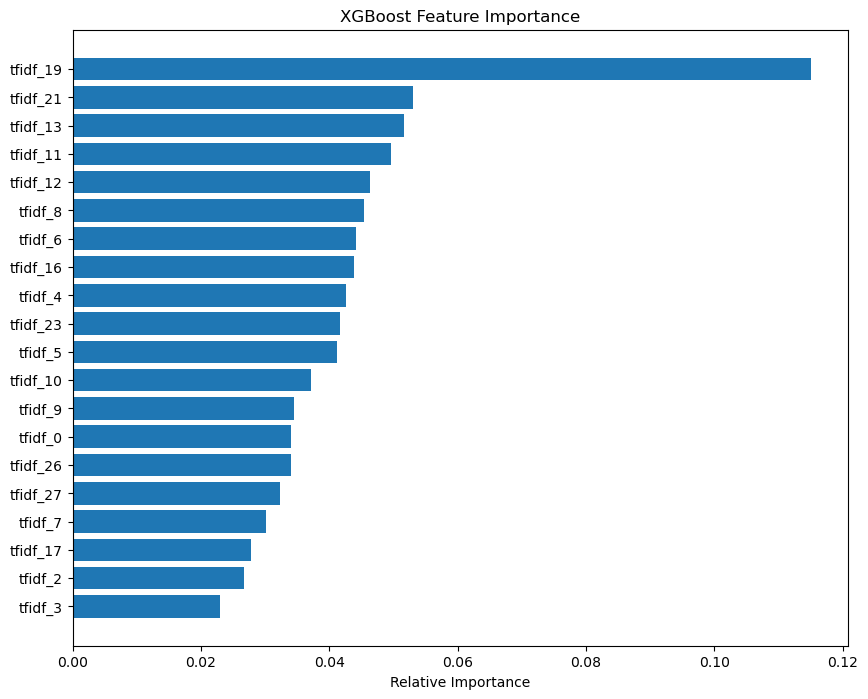

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, classification_report, confusion_matrix)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Load and clean data
df = pd.read_csv('/Users/sarayu.mangapathi/Downloads/crime_dataset_india.csv')
df = df.dropna(subset=['Crime Description', 'City', 'Victim Gender', 'Date of Occurrence'])

# Feature engineering
df['Hour'] = pd.to_datetime(df['Time of Occurrence'], errors='coerce').dt.hour.fillna(12)
df['DayOfWeek'] = pd.to_datetime(df['Date of Occurrence']).dt.dayofweek
df['Month'] = pd.to_datetime(df['Date of Occurrence']).dt.month

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(df['Crime Description'])

# Define features
categorical_features = ['City', 'Victim Gender']
numeric_features = ['Hour', 'DayOfWeek', 'Month', 'Victim Age']
text_feature = 'Crime Description'

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('text', TfidfVectorizer(max_features=100), text_feature)
    ])

# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df[['City', 'Victim Gender', 'Hour', 'DayOfWeek', 'Month', 'Victim Age', 'Crime Description']], 
    y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)  # 0.25 x 0.8 = 0.2

## Model 1: Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

## Model 2: XGBoost with proper early stopping
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=len(le.classes_),
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        early_stopping_rounds=10,
        eval_metric='mlogloss'))
])

# Fit with validation set
xgb_pipeline.fit(
    X_train, y_train,
    classifier__eval_set=[(xgb_pipeline.named_steps['preprocessor'].transform(X_val), y_val)],
    classifier__verbose=True
)

y_pred_xgb = xgb_pipeline.predict(X_test)

## Evaluation Metrics
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Evaluation:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Weighted Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Weighted Recall:", recall_score(y_true, y_pred, average='weighted'))
    print("Weighted F1-score:", f1_score(y_true, y_pred, average='weighted'))
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    
    # Confusion matrix for top 15 crimes
    top_classes = np.unique(y_true)[:15]
    cm = confusion_matrix(y_true, y_pred, labels=top_classes)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=le.classes_[top_classes], 
                yticklabels=le.classes_[top_classes])
    plt.title(f'{model_name} Confusion Matrix (Top 15 Crimes)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")

## Feature Importance Analysis
# For Random Forest
rf_feature_importances = rf_pipeline.named_steps['classifier'].feature_importances_
# For XGBoost
xgb_feature_importances = xgb_pipeline.named_steps['classifier'].feature_importances_

# Get feature names
numeric_features = numeric_features
cat_features = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
text_features = [f"tfidf_{i}" for i in range(100)]
all_features = numeric_features + list(cat_features) + text_features

# Plot importances
def plot_importances(importances, features, title, top_n=20):
    indices = np.argsort(importances)[-top_n:]
    plt.figure(figsize=(10,8))
    plt.title(title)
    plt.barh(range(top_n), importances[indices], align='center')
    plt.yticks(range(top_n), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

plot_importances(rf_feature_importances, all_features, "Random Forest Feature Importance")
plot_importances(xgb_feature_importances, all_features, "XGBoost Feature Importance")

In [34]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.3/492.3 kB 5.1 MB/s eta 0:00:00a 0:00:01


SHAP Values Type: <class 'numpy.ndarray'>
SHAP values shape: (8032, 64, 21)
First few SHAP values:
 [[[ 1.6404639e-03  0.0000000e+00  0.0000000e+00 ...  1.4079316e-04
    0.0000000e+00  1.0709502e-03]
  [ 6.2570153e-03 -1.3240094e-03  1.1327777e-03 ...  0.0000000e+00
   -5.9031611e-03  1.2194650e-03]
  [ 7.5044315e-03 -2.5844860e-03  8.6579705e-04 ... -5.7191709e-03
   -7.4863492e-05  0.0000000e+00]
  ...
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
    0.0000000e+00  9.0495789e-01]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.2280390e+00
    0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]]

 [[ 8.8556047e-04  0.0000000e+00  0.0000000e+00 ...  2.2927354e-04
    0.0000000e+00  6.5671990e-04]
  [-2.6154730e-03  3.7798493e-03  1.1327777e-03 ...  0.0000000e+00
   -1.1997501e-02 -3.2770261e-03]
  [-1.3797131e-02  2.1473886e-03 -5.0746353e-04 ...  2.2883720e-03
    1.6600091e-03

<Figure size 640x480 with 0 Axes>

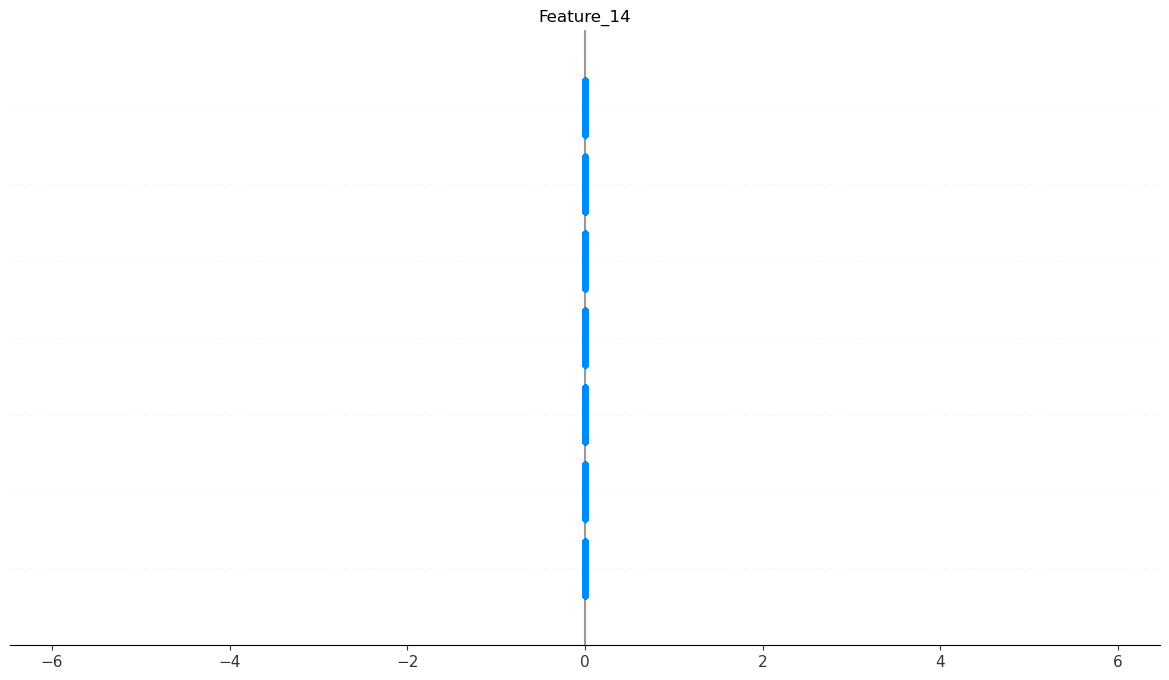

Generating SHAP bar plot...


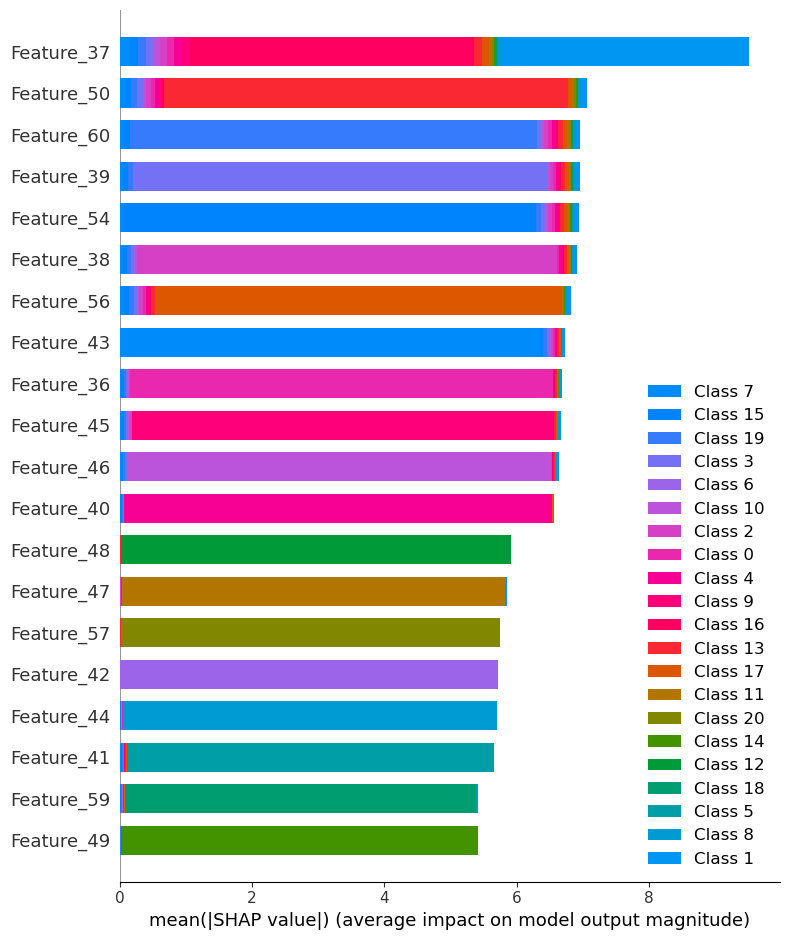

In [48]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse

# Ensure data is processed
X_test_processed = xgb_pipeline.named_steps['preprocessor'].transform(X_test)

# Convert sparse matrix to dense
if scipy.sparse.issparse(X_test_processed):
    X_test_processed = X_test_processed.toarray()

# Ensure SHAP values are computed
explainer = shap.TreeExplainer(xgb_pipeline.named_steps['classifier'])
shap_values = explainer.shap_values(X_test_processed)

# Debug SHAP values
print("SHAP Values Type:", type(shap_values))

if isinstance(shap_values, list):
    print(f"SHAP values list length: {len(shap_values)}")
    if len(shap_values) > 0:
        print(f"SHAP values shape (first element): {shap_values[0].shape}")
        print(f"First few SHAP values:\n {shap_values[0][:5]}")
else:
    print(f"SHAP values shape: {shap_values.shape}")
    print(f"First few SHAP values:\n {shap_values[:5]}")

# Check if SHAP values are zero
if isinstance(shap_values, np.ndarray) and np.all(shap_values == 0):
    print("⚠️ Warning: All SHAP values are zero!")

# Ensure model is making real predictions
y_pred = xgb_pipeline.predict(X_test)
print("First 10 predictions:", y_pred[:10])
print("Unique predicted classes:", np.unique(y_pred))

# Ensure feature names match
print("X_test_processed shape:", X_test_processed.shape)
print("Feature names count:", len(all_features))

if X_test_processed.shape[1] != len(all_features):
    print("⚠️ Warning: Feature mismatch detected!")
    all_features = [f"Feature_{i}" for i in range(X_test_processed.shape[1])]

# Convert SHAP values for classification
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Get SHAP values for positive class

# Try SHAP plots
print("Generating SHAP summary plot...")
shap.summary_plot(shap_values, feature_names=all_features)

print("Generating SHAP bar plot...")
shap.summary_plot(shap_values, X_test_processed, feature_names=all_features, plot_type="bar")

In [39]:
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 7.0 MB/s eta 0:00:0000:0100:01m


In [46]:
print(df.columns)

Index(['Report Number', 'Date Reported', 'Date of Occurrence',
       'Time of Occurrence', 'City', 'Crime Code', 'Crime Description',
       'Victim Age', 'Victim Gender', 'Weapon Used', 'Crime Domain',
       'Police Deployed', 'Case Closed', 'Date Case Closed', 'Hour',
       'DayOfWeek', 'Month', 'Latitude', 'Longitude'],
      dtype='object')
